In [ ]:
# %% Import Libraries

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

In [ ]:
# %% Load Cleaned Data

train_data = pd.read_csv("data/train_data_cleaned.csv")
test_data = pd.read_csv("data/test_data_cleaned.csv")

train_data["time"] = pd.to_datetime(train_data["time"])
test_data["time"] = pd.to_datetime(test_data["time"])

train_data.set_index("time", inplace=True)
test_data.set_index("time", inplace=True)

# Target Variable and Exogenous Inputs
y_train = train_data["demand"]
y_test = test_data["demand"]
exog_train = train_data[["temp"]]
exog_test = test_data[["temp"]]

In [ ]:
# %% Rolling Forecast Setup

horizon = 24  # 24-hour horizon
steps = len(y_test) // horizon  # Number of rolling windows
print(f"Number of rolling forecast steps: {steps}")

# Initialize lists for forecasts
sarima_forecast_values = []
sarimax_forecast_values = []
drift_forecast_values = []
snaive_forecast_values = []

Number of rolling forecast steps: 7


In [ ]:
# %% Rolling Out-of-Sample Forecasting

for i in range(0, len(y_test) - horizon + 1, horizon):
    rolling_y_train = pd.concat([y_train, y_test.iloc[:i]])
    rolling_exog_train = pd.concat([exog_train, exog_test.iloc[:i]])
    rolling_exog_test = exog_test.iloc[i : i + horizon]
    rolling_y_test = y_test.iloc[i : i + horizon]

    # --- 1. SARIMA Model ---
    sarima = ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 24))
    sarima_results = sarima.fit(rolling_y_train)
    sarima_forecast_values.extend(sarima_results.predict(n_periods=horizon))

    # --- 2. SARIMAX Model ---
    sarimax = ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 24))
    sarimax_results = sarimax.fit(rolling_y_train, X=rolling_exog_train)
    sarimax_forecast_values.extend(
        sarimax_results.predict(n_periods=horizon, X=rolling_exog_test)
    )

    # --- 3. Drift Forecast --- equal to ARIMA(0,1,0)
    drift = ARIMA(order=(0, 1, 0))
    drift_results = drift.fit(rolling_y_train)
    drift_forecast_values.extend(drift_results.predict(n_periods=horizon))

    # --- 4. Naive Forecast --- equal to ARIMA(0,0,0)(0,1,0)m
    snaive = ARIMA(order=(0, 0, 0), seasonal_order=(0, 1, 0, 24))
    snaive_results = snaive.fit(rolling_y_train)
    snaive_forecast_values.extend(snaive_results.predict(n_periods=horizon))


# Convert forecasts to Series
sarima_forecast = pd.Series(
    sarima_forecast_values, index=y_test.index[: len(sarima_forecast_values)]
)
sarimax_forecast = pd.Series(
    sarimax_forecast_values,
    index=y_test.index[: len(sarimax_forecast_values)],
)
drift_forecast = pd.Series(
    drift_forecast_values, index=y_test.index[: len(drift_forecast_values)]
)
snaive_forecast = pd.Series(
    snaive_forecast_values,
    index=y_test.index[: len(snaive_forecast_values)],
)

In [ ]:
# %% Evaluate Forecast Performance

mae_sarima = mean_absolute_error(y_test[: len(sarima_forecast)], sarima_forecast)
mae_sarimax = mean_absolute_error(y_test[: len(sarimax_forecast)], sarimax_forecast)
mae_drift = mean_absolute_error(y_test[: len(drift_forecast)], drift_forecast)
mae_snaive = mean_absolute_error(y_test[: len(snaive_forecast)], snaive_forecast)

print("\n--- Forecast Performance ---")
print(f"MAE (SARIMA): {mae_sarima:.4f}")
print(f"MAE (SARIMAX): {mae_sarimax:.4f}")
print(f"MAE (Drift Forecast): {mae_drift:.4f}")
print(f"MAE (Seasonal Naive Forecast): {mae_snaive:.4f}")


--- Forecast Performance ---
MAE (SARIMA): 0.3350
MAE (SARIMAX): 0.3365
MAE (Drift Forecast): 0.4352
MAE (Seasonal Naive Forecast): 0.4127


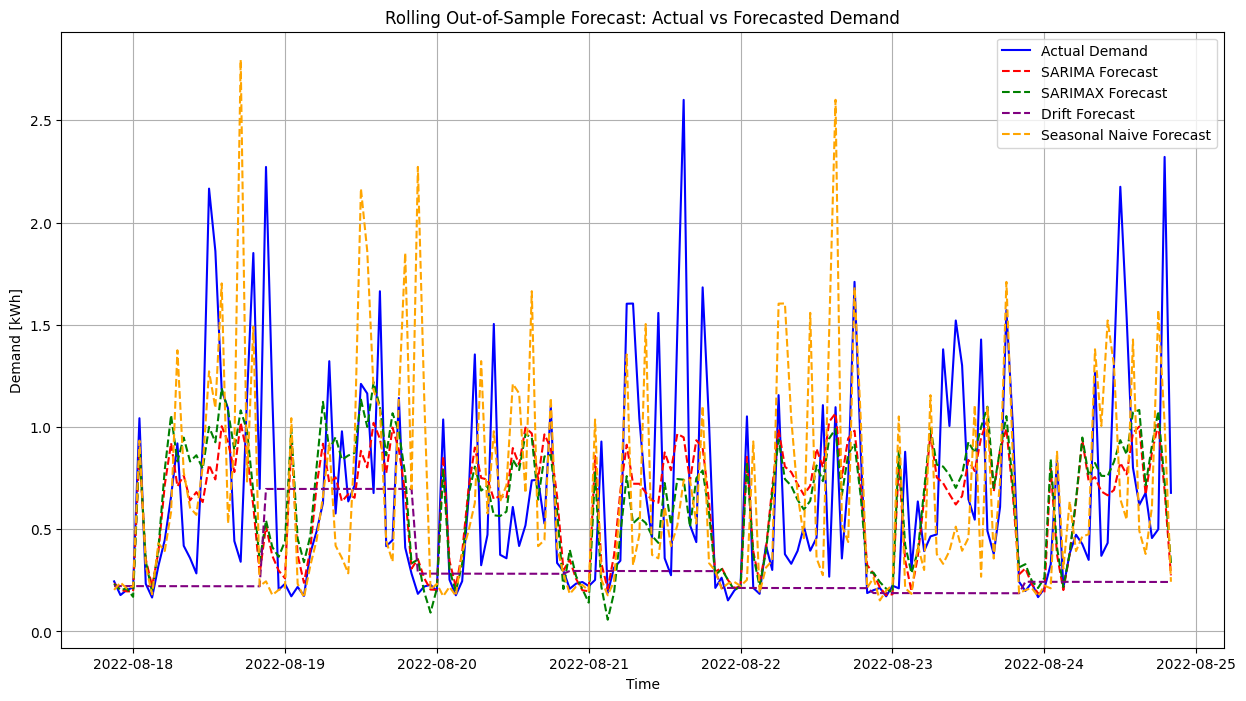

In [ ]:
# %% Visualize Forecasts

plt.figure(figsize=(15, 8))
plt.plot(y_test, label="Actual Demand", color="blue")
plt.plot(sarima_forecast, label="SARIMA Forecast", linestyle="--", color="red")
plt.plot(
    sarimax_forecast,
    label="SARIMAX Forecast",
    linestyle="--",
    color="green",
)
plt.plot(drift_forecast, label="Drift Forecast", linestyle="--", color="purple")
plt.plot(
    snaive_forecast, label="Seasonal Naive Forecast", linestyle="--", color="orange"
)

plt.title("Rolling Out-of-Sample Forecast: Actual vs Forecasted Demand")
plt.xlabel("Time")
plt.ylabel("Demand [kWh]")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# %% Final Comparison of All Models

print("\n--- Final Model Comparison ---")
print(f"MAE (SARIMA): {mae_sarima:.4f}")
print(f"MAE (SARIMAX): {mae_sarimax:.4f}")
print(f"MAE (Drift Forecast): {mae_drift:.4f}")
print(f"MAE (Seasonal Naive Forecast): {mae_snaive:.4f}")

# Determine the best-performing model
mae_dict = {
    "SARIMA": mae_sarima,
    "SARIMAX": mae_sarimax,
    "Drift Forecast": mae_drift,
    "Seasonal Naive Forecast": mae_snaive,
}

best_model = min(mae_dict, key=mae_dict.get)
print(f"\nThe best-performing model is: {best_model}")


--- Final Model Comparison ---
MAE (SARIMA): 0.3350
MAE (SARIMAX): 0.3365
MAE (Drift Forecast): 0.4352
MAE (Seasonal Naive Forecast): 0.4127

The best-performing model is: SARIMA
